In [1]:
# Testing CCARLClassifier

In [1]:
from sklearn.model_selection import StratifiedKFold

In [2]:
import pandas as pd
import numpy as np
import os
from ccarl.ccarl import CCARLClassifier, _calculate_binders, _log_rfu_values
from ccarl.glycan_parsers.cfg_array_versions import get_likely_cfg_array_version

from ccarl.glycan_plotting import draw_glycan_diagram
import ccarl
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import interp
from sklearn.metrics import matthews_corrcoef, make_scorer, roc_curve, auc

os.environ["OMP_NUM_THREADS"] = "4"


In [3]:

def plot_multiple_roc(data):
    '''Plot multiple ROC curves.
    
    Prints out key AUC values (mean, median etc).
    
    Args:
        data (list): A list containing [y, probs] for each model, where:
            y: True class labels
            probs: Predicted probabilities
    Returns:
        Figure, Axes, Figure, Axes
    '''
    mean_fpr = np.linspace(0, 1, 100)

    fig, axes = plt.subplots(figsize=(4, 4))

    ax = axes
    ax.set_title('')
    #ax.legend(loc="lower right")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_aspect('equal', adjustable='box')
    auc_values = []
    tpr_list = []

    for y, probs in data:
        #data_point = data[csv_file]
        #y = data_point[7] # test binding
        #X = data_point[8] # test features
        #logistic_clf = data_point[0] # model
        fpr, tpr, _ = roc_curve(y, probs, drop_intermediate=False)
        tpr_list.append(interp(mean_fpr, fpr, tpr))
        auc_values.append(auc(fpr, tpr))
        ax.plot(fpr, tpr, color='blue', alpha=0.1, label=f'ROC curve (area = {auc(fpr, tpr): 2.3f})')
        ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))

    mean_tpr = np.mean(tpr_list, axis=0)
    median_tpr = np.median(tpr_list, axis=0)
    upper_tpr = np.percentile(tpr_list, 75, axis=0)
    lower_tpr = np.percentile(tpr_list, 25, axis=0)
    ax.plot(mean_fpr, median_tpr, color='black')

    ax.fill_between(mean_fpr, lower_tpr, upper_tpr, color='grey', alpha=.5,
                     label=r'$\pm$ 1 std. dev.')
    fig.savefig("CV_ROC_plot_all_curves.svg")

    fig2, ax2 = plt.subplots(figsize=(4, 4))
    ax2.hist(auc_values, range=[0.5,1], bins=10, rwidth=0.9, color=(0, 114/255, 178/255))
    ax2.set_xlabel("AUC value")
    ax2.set_ylabel("Counts")
    fig2.savefig("CV_AUC_histogram.svg")

    print(f"Mean AUC value: {np.mean(auc_values): 1.3f}")

    print(f"Median AUC value: {np.median(auc_values): 1.3f}")
    print(f"IQR of AUC values: {np.percentile(auc_values, 25): 1.3f} - {np.percentile(auc_values, 75): 1.3f}")
    return fig, axes, fig2, ax2

def plot_test_training_roc(model, y_test, glycan_test, y_train, glycan_train, outprefix):
    '''Plot multiple ROC curves.
    
    Prints out key AUC values (mean, median etc).
    
    Args:
        model: CCARLClassifier object
        y_test: Array of binary binding classes (test set)
        glycan_test: List of glycans from test set
        y_train: Array of binary binding classes (training set)
        glycan_train: List of glycans from training set
        outprefix: Prefix for saved file.
    Returns:
        Axes
    '''
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    clf = model
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(glycan_test)[:,1], drop_intermediate=False)
    fpr_train, tpr_train, _ = roc_curve(y_train, clf.predict_proba(glycan_train)[:,1], drop_intermediate=False)
    ax.plot(fpr, tpr, color=(0, 0.45, 0.70), label=f'Test, AUC:{auc(fpr, tpr): 2.2f}')
    ax.plot(fpr_train, tpr_train, color=(0.8, 0.4, 0), label=f'Training, AUC:{auc(fpr_train, tpr_train): 2.2f}')
    ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))
    ax.legend()
    fig.savefig(f'{outprefix}_CV_ROC_Curves.svg')
    return ax


def plot_test_training_roc_ax(model, y_test, glycan_test, y_train, glycan_train, ax):
    '''Plot multiple ROC curves.
    
    Prints out key AUC values (mean, median etc).
    
    Args:
        model: CCARLClassifier object
        y_test: Array of binary binding classes (test set)
        glycan_test: List of glycans from test set
        y_train: Array of binary binding classes (training set)
        glycan_train: List of glycans from training set
        outprefix: Prefix for saved file.
    Returns:
        Axes
    '''
    ax.set_title('')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    clf = model
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(glycan_test)[:,1], drop_intermediate=False)
    fpr_train, tpr_train, _ = roc_curve(y_train, clf.predict_proba(glycan_train)[:,1], drop_intermediate=False)
    ax.plot(fpr, tpr, color=(0, 0.45, 0.70), label=f'Test, AUC:{auc(fpr, tpr): 2.2f}')
    ax.plot(fpr_train, tpr_train, color=(0.8, 0.4, 0), label=f'Training, AUC:{auc(fpr_train, tpr_train): 2.2f}')
    ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))
    ax.legend()
    return ax

In [4]:
csv_files = ["ABA_14361_100ug_v5.0_DATA.csv",
             "ConA_13799-10ug_V5.0_DATA.csv",
             'PNA_14030_10ug_v5.0_DATA.csv',
             "RCAI_10ug_14110_v5.0_DATA.csv",
             "PHA-E-10ug_13853_V5.0_DATA.csv",
             "PHA-L-10ug_13856_V5.0_DATA.csv",
             "LCA_10ug_13934_v5.0_DATA.csv",
             "SNA_10ug_13631_v5.0_DATA.csv",
             "MAL-I_10ug_13883_v5.0_DATA.csv",
             "MAL_II_10ug_13886_v5.0_DATA.csv",
             "GSL-I-B4_10ug_13920_v5.0_DATA.csv",
             "jacalin-1ug_14301_v5.0_DATA.csv", # Not a vector labs, but can't find one in the data. Only EY.
             'WGA_14057_1ug_v5.0_DATA.csv',
             "UEAI_100ug_13806_v5.0_DATA.csv",
             "SBA_14042_10ug_v5.0_DATA.csv",
             "DBA_100ug_13897_v5.0_DATA.csv",
             "PSA_14040_10ug_v5.0_DATA.csv",
             "HA_PuertoRico_8_34_13829_v5_DATA.csv",
             'H3N8-HA_16686_v5.1_DATA.csv',
             "Human-DC-Sign-tetramer_15320_v5.0_DATA.csv"]

In [5]:
results = {}

In [6]:
results.keys()

dict_keys([])

In [ ]:
import importlib
import ccarl
importlib.reload(ccarl)

import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")

DATA_DIR = './Data/CV_Folds'

for csv_file in csv_files:
    results[csv_file] = {}
    for fold in [1, 2, 3, 4, 5]:
        results[csv_file][fold] = {}
        train_data = pd.read_csv(os.path.join(DATA_DIR, f"fold_{fold}", 'training_set_' + csv_file))
        test_data = pd.read_csv(os.path.join(DATA_DIR, f"fold_{fold}", 'test_set_' + csv_file))
        cf = ccarl.ccarl.CCARLClassifier(num_mrmr_features=10)
        
        cf.train(train_data.glycan, train_data.binding)
        results[csv_file][fold]['model'] = cf
        results[csv_file][fold]['test'] = test_data
        results[csv_file][fold]['train'] = train_data

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero 

In [7]:
import pickle

if results.keys():
    with open('pickled_cv_results', 'wb') as f:
        pickle.dump(results, f)
else:
    with open('pickled_cv_results', 'rb') as f:
        results = pickle.load(f)

Mean AUC value:  0.895
Median AUC value:  0.913
IQR of AUC values:  0.839 -  0.959


(<Figure size 288x288 with 1 Axes>,
 <Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f376dfe3358>)

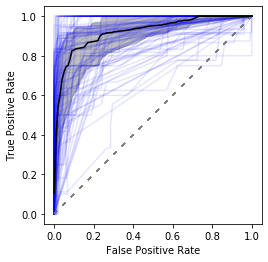

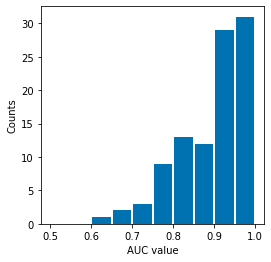

In [8]:
# Plot ROC curves for all test sets
roc_data = [[results[x][fold]['test'].binding.values, results[x][fold]['model'].predict_proba(results[x][fold]['test'].glycan)[:,1]] for x in csv_files for fold in [1, 2, 3, 4, 5]]
plot_multiple_roc(roc_data)

In [15]:
# Generate table for tex document
folds = [1,2,3,4,5]
for csv_file in csv_files:
    data_point = results[csv_file]
    ys = [data_point[fold]['test'].binding.values for fold in folds]
    Xs = [data_point[fold]['test'].glycan for fold in folds]
    clfs = [data_point[fold]['model'] for fold in folds]
    y_trains = [data_point[fold]['train'].binding.values for fold in folds]
    X_trains = [data_point[fold]['train'].glycan for fold in folds]
    roc_results = [roc_curve(y, clf.predict_proba(X)[:,1], drop_intermediate=False) for X, y, clf in zip(Xs, ys, clfs)]
    roc_results_tr = [roc_curve(y_train, clf.predict_proba(X_train)[:,1], drop_intermediate=False) for X_train, y_train, clf in zip(X_trains, y_trains, clfs)]
    aucs = [auc(fpr, tpr) for fpr, tpr, _ in roc_results]
    aucs_tr = [auc(fpr, tpr) for fpr, tpr, _ in roc_results_tr]
    print(f"{csv_file} & {np.mean(aucs):1.3f} ({np.std(aucs):1.3f}) & {np.mean(aucs_tr):1.3f} ({np.std(aucs_tr):1.3f}) &.. & \\\\")

ABA_14361_100ug_v5.0_DATA.csv & 0.934 (0.034) & 0.947 (0.006) &.. & \\
ConA_13799-10ug_V5.0_DATA.csv & 0.971 (0.031) & 0.982 (0.015) &.. & \\
PNA_14030_10ug_v5.0_DATA.csv & 0.914 (0.048) & 0.943 (0.021) &.. & \\
RCAI_10ug_14110_v5.0_DATA.csv & 0.953 (0.026) & 0.958 (0.008) &.. & \\
PHA-E-10ug_13853_V5.0_DATA.csv & 0.959 (0.018) & 0.975 (0.009) &.. & \\
PHA-L-10ug_13856_V5.0_DATA.csv & 0.914 (0.126) & 0.967 (0.030) &.. & \\
LCA_10ug_13934_v5.0_DATA.csv & 0.964 (0.032) & 0.976 (0.008) &.. & \\
SNA_10ug_13631_v5.0_DATA.csv & 0.950 (0.060) & 0.979 (0.010) &.. & \\
MAL-I_10ug_13883_v5.0_DATA.csv & 0.833 (0.035) & 0.848 (0.053) &.. & \\
MAL_II_10ug_13886_v5.0_DATA.csv & 0.718 (0.078) & 0.814 (0.074) &.. & \\
GSL-I-B4_10ug_13920_v5.0_DATA.csv & 0.867 (0.061) & 0.953 (0.014) &.. & \\
jacalin-1ug_14301_v5.0_DATA.csv & 0.882 (0.055) & 0.896 (0.009) &.. & \\
WGA_14057_1ug_v5.0_DATA.csv & 0.882 (0.021) & 0.901 (0.004) &.. & \\
UEAI_100ug_13806_v5.0_DATA.csv & 0.861 (0.049) & 0.895 (0.042) &.. & \\

In [9]:
from matplotlib.lines import Line2D

def plot_kfold_test_training_roc(models, y_tests, glycan_tests, y_trains, glycan_trains, outprefix):
    '''Plot multiple ROC curves.
    
    Prints out key AUC values (mean, median etc).
    
    Args:
        model: CCARLClassifier object
        y_tests: List of arrays of binary binding classes (test set)
        glycan_tests: List of list of glycans from test set
        y_trains: List of arrays of binary binding classes (training set)
        glycan_trains: List of list of glycans from training set
        outprefix: Prefix for saved file.
    Returns:
        Axes
    '''
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    aucs = []
    aucs_tr = []
    for model, y_test, glycan_test, y_train, glycan_train in zip(models, y_tests, glycan_tests, y_trains, glycan_trains):
        clf = model
        fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(glycan_test)[:,1], drop_intermediate=False)
        fpr_train, tpr_train, _ = roc_curve(y_train, clf.predict_proba(glycan_train)[:,1], drop_intermediate=False)
        auc_ = auc(fpr, tpr)
        auc_tr = auc(fpr_train, tpr_train)
        aucs.append(auc_)
        aucs_tr.append(auc_tr)
        ax.plot(fpr, tpr, color=(0, 0.45, 0.70), alpha=0.5, label=f'Test, AUC:{auc_: 2.2f}')
        ax.plot(fpr_train, tpr_train, color=(0.8, 0.4, 0), alpha=0.5, label=f'Training, AUC:{auc_tr: 2.2f}')
        
    ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))
    custom_lines = [Line2D([0], [0], color=(0, 0.45, 0.70), alpha=0.5),
                    Line2D([0], [0], color=(0.8, 0.4, 0), alpha=0.5)]
    ax.legend(custom_lines, [f'Test, AUC: {np.mean(aucs):2.2f} ({np.std(aucs):2.2f})', 
                             f'Training, AUC:{np.mean(aucs_tr):2.2f} ({np.std(aucs_tr):2.2f})'])
    fig.savefig(f'{outprefix}_ROC_Curves.svg')
    return ax

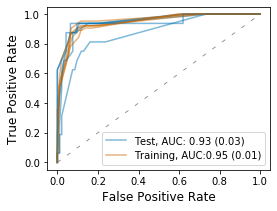

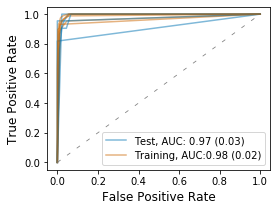

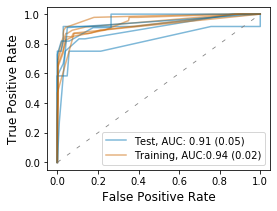

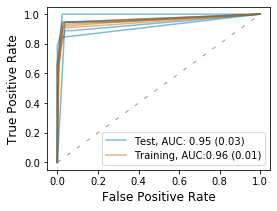

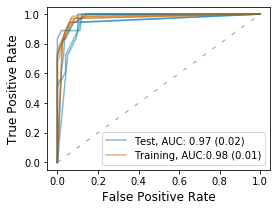

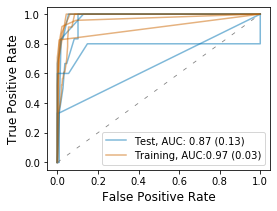

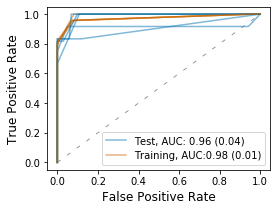

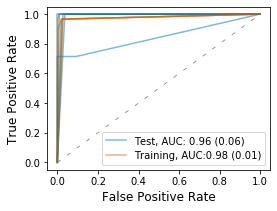

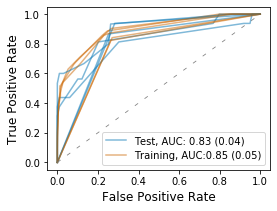

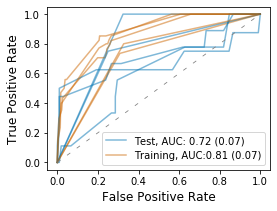

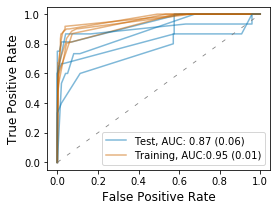

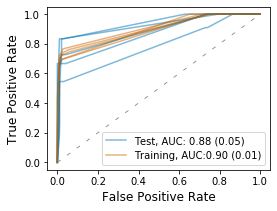

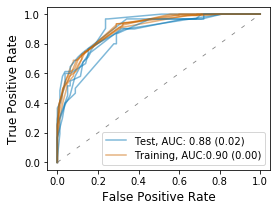

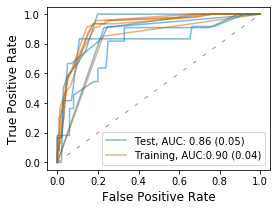

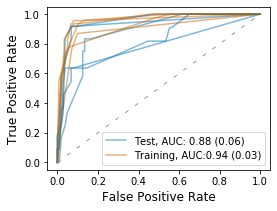

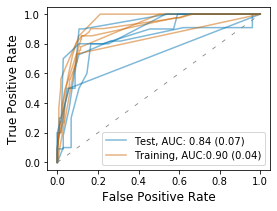

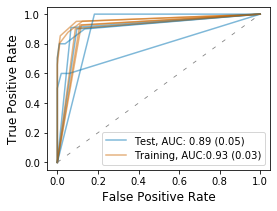

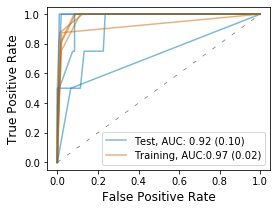

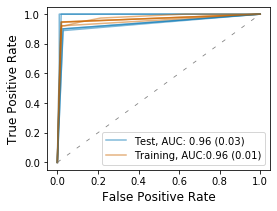

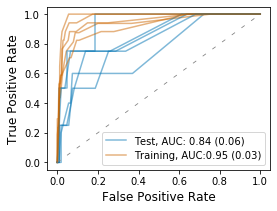

In [12]:
# Plot ROC curves for test and training sets
folds = [1,2,3,4,5]
for csv_file in csv_files:
    data_point = results[csv_file]
    models = [data_point[fold]['model'] for fold in folds]
    y_tests = [data_point[fold]['test'].binding.values for fold in folds]
    glycan_tests = [data_point[fold]['test'].glycan for fold in folds]
    y_trains = [data_point[fold]['train'].binding.values for fold in folds]
    glycan_trains = [data_point[fold]['train'].glycan for fold in folds]
    _ = plot_kfold_test_training_roc(models, y_tests, glycan_tests, y_trains, glycan_trains, f'./Figures/ROC_CV/{csv_file}')

/home/andrew/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


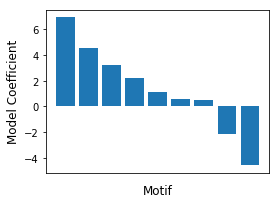

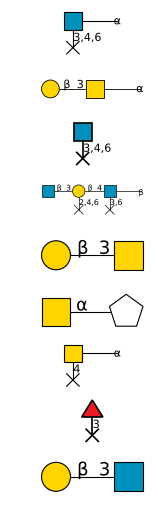

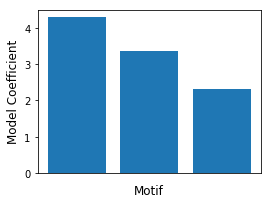

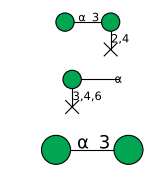

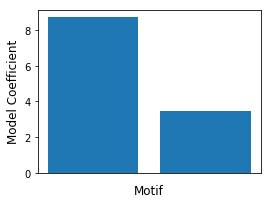

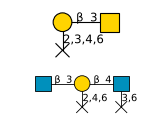

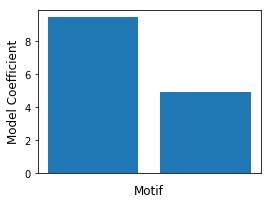

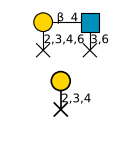

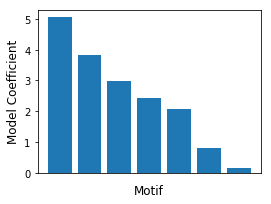

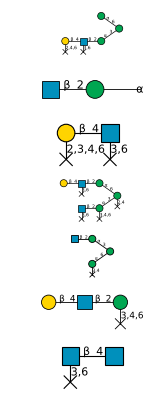

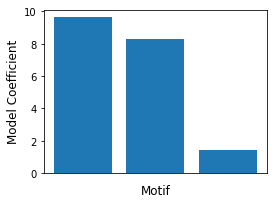

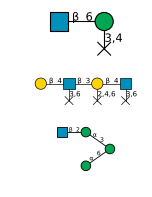

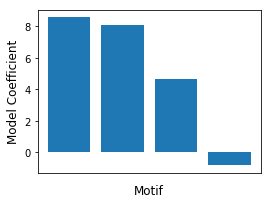

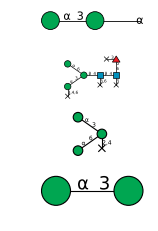

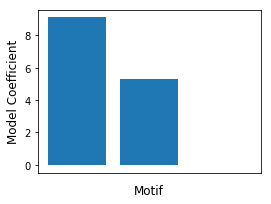

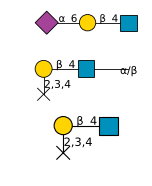

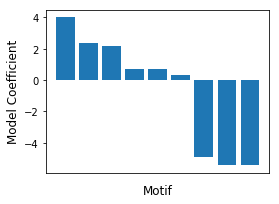

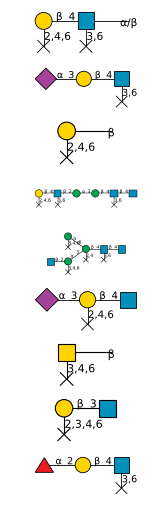

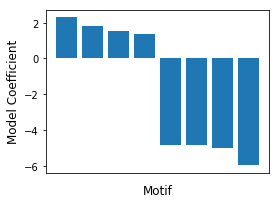

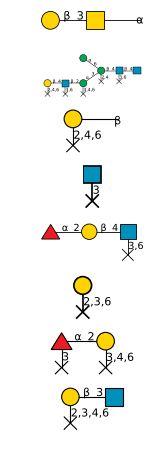

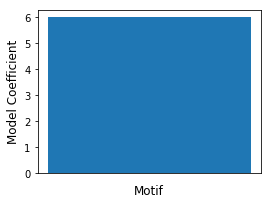

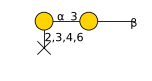

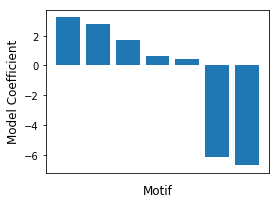

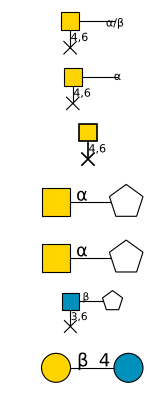

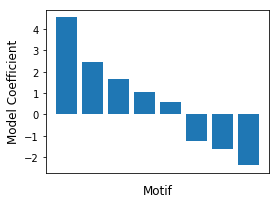

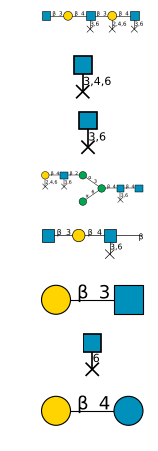

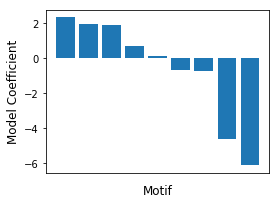

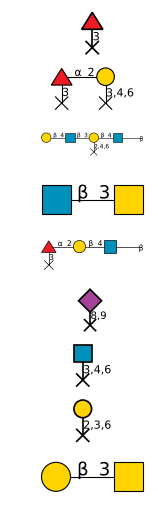

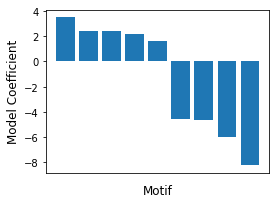

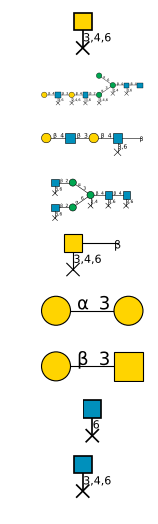

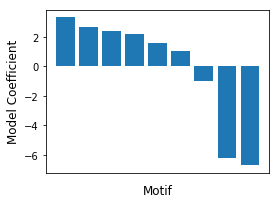

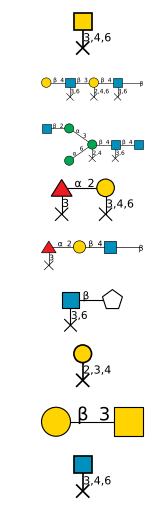

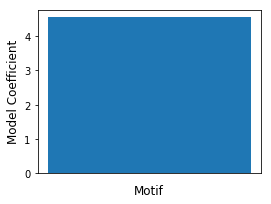

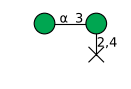

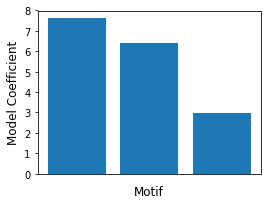

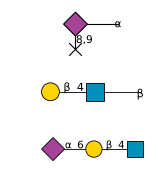

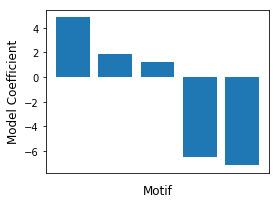

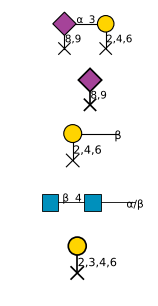

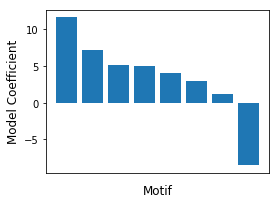

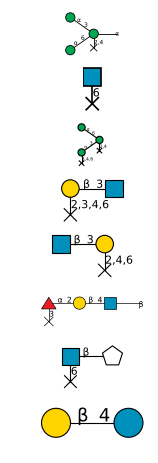

In [27]:
def plot_model_coefficient(model, outprefix):
    fig, ax = plt.subplots(figsize=(4, 3))
    coefs = model._model.coef_[0]
    ax.set_title('')
    ax.set_xlabel('Motif', fontsize=12)
    ax.set_ylabel('Model Coefficient', fontsize=12)
    ax.bar(range(0, len(coefs)), sorted(coefs, key=lambda x: -x))
    #ax.set_ylim([-10, 20])
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('none') 
    fig.savefig(f'{outprefix}_Coefficients.svg')
    return

def plot_model_glycans(model, outprefix):
    coefs = model._model.coef_[0]
    features = model.subtree_features
    sorted_features = [x for _, x in sorted(zip(coefs, features), key=lambda pair: -pair[0])]
    fig, ax = plt.subplots(nrows=len(coefs), figsize=(2, 1 * len(coefs)))
    if len(coefs) == 1:
        ax = [ax,]
    for i, feature in enumerate(sorted_features):
        draw_glycan_diagram(feature, ax[i], draw_terminal_connection_labels=True)
    fig.savefig(f'{outprefix}_motifs.svg')
    return

for csv_file in csv_files:
    data_point = results[csv_file]
    plot_model_coefficient(data_point['model'], f'./Figures/Coefficients/{csv_file}')
    plot_model_glycans(data_point['model'], f'./Figures/Coefficients/{csv_file}')

In [10]:
def plot_log_rfu_histogram(x, binding_classes, ax, title=''):
    '''Plot a histogram of counts and show positive and intermediate binders.

    Args:
        x: log RFU values
        ax (AxesSubplot): Matplotlib figure axis.
        title (str, optional): Title for figure.
        thresholds (tuple, optional): Modified z-score thresholds for intermediate and
            positive binders.

    Returns:
        AxesSubplot: Matplotlib figure axis, to allow method chaining.
    '''
    binwidth = 0.05
    data_neg = x[binding_classes == 0]
    data_pos = x[binding_classes == 2]
    data_int = x[binding_classes == 1]
    ax.hist(data_neg, bins=np.arange(min(data_neg), max(data_neg) + binwidth, binwidth))
    # Sometimes there aren't any intermediates or positives...
    if len(data_pos) != 0:
        ax.hist(data_pos, bins=np.arange(min(data_pos), max(data_pos) + binwidth, binwidth),
                color='red')
    if len(data_int) != 0:
        bins = np.arange(min(data_int), max(data_int) + binwidth, binwidth)
        ax.hist(data_int, bins=bins, color='orange')
    ax.set_title(title)
    ax.set_xlabel('log(RFU)')
    ax.set_ylabel('Counts')
    return ax

In [14]:
DATA_DIR = './Data'

for csv_file in csv_files:
    results[csv_file] = {}
    train_data = pd.read_csv(os.path.join(DATA_DIR, 'training_set', 'training_set_' + csv_file))
    test_data = pd.read_csv(os.path.join(DATA_DIR, 'test_set', 'test_set_' + csv_file))
    cf = ccarl.ccarl.CCARLClassifier(num_mrmr_features=10)
    cf.train(train_data.glycan, train_data.binding)
    results[csv_file]['model'] = cf
    results[csv_file]['test'] = test_data
    results[csv_file]['train'] = train_data

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.

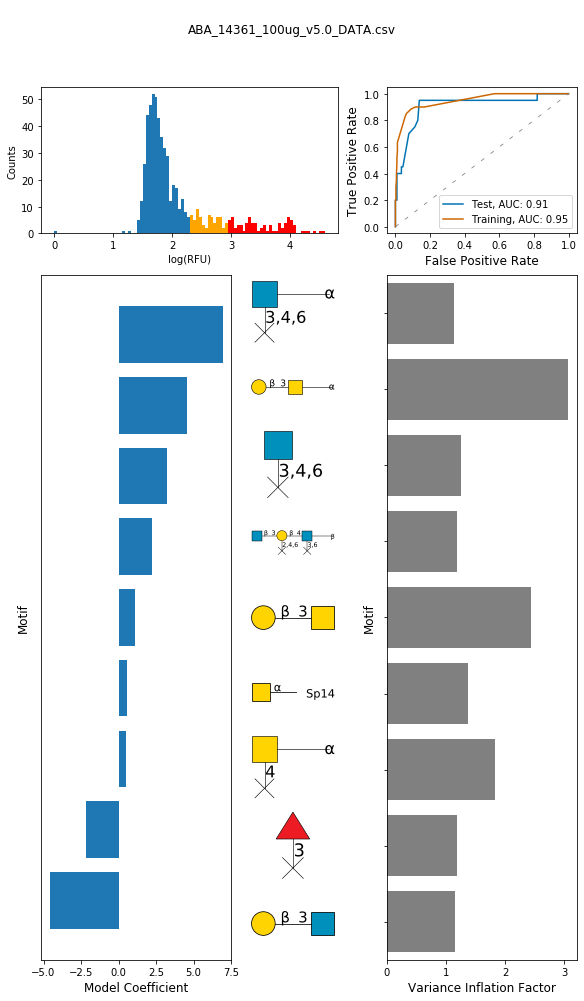

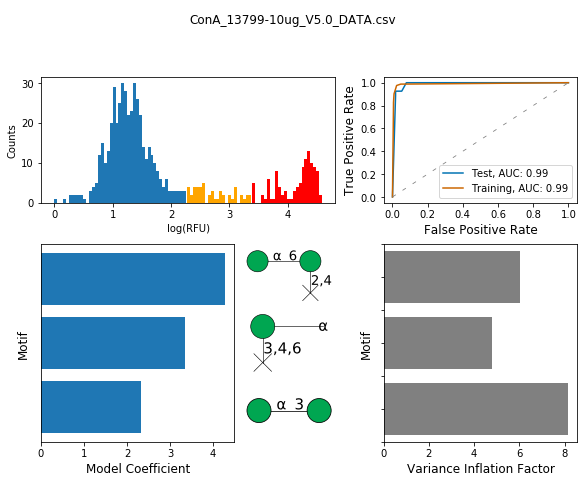

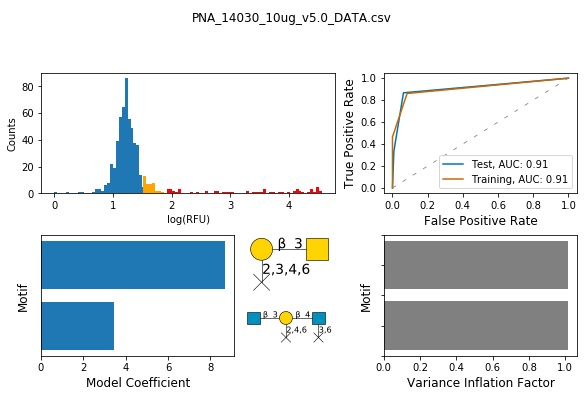

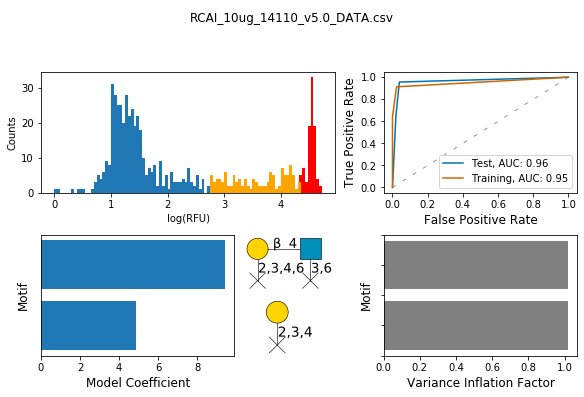

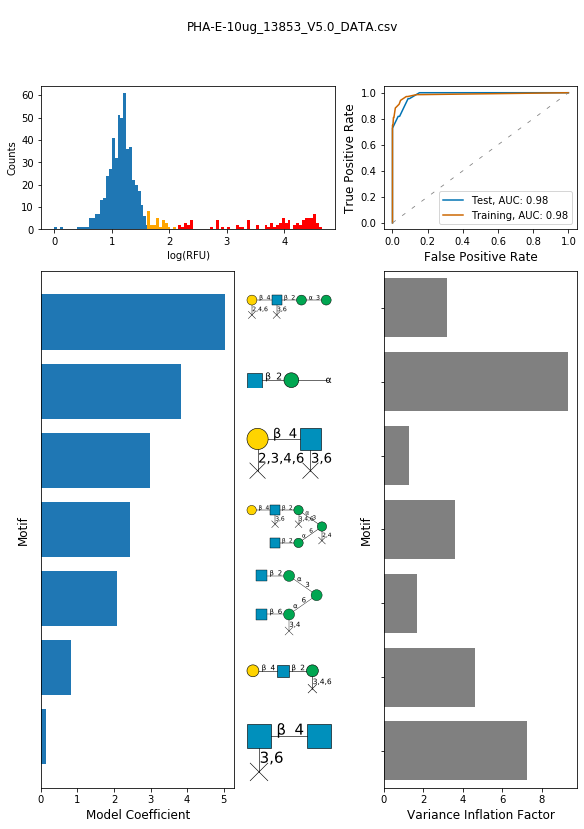

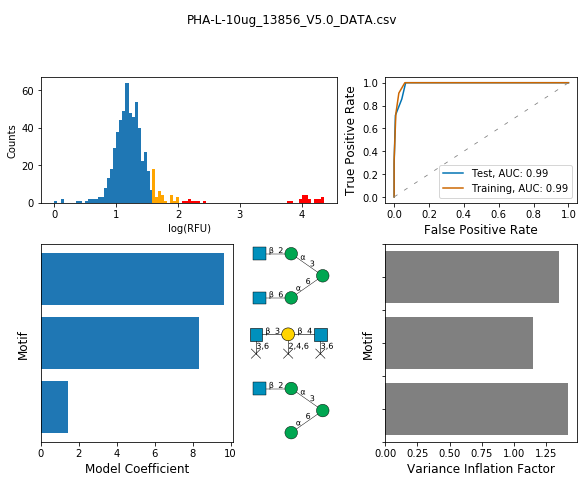

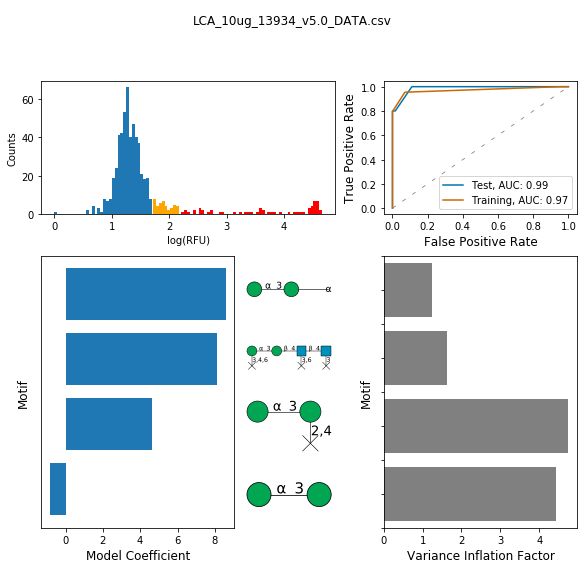

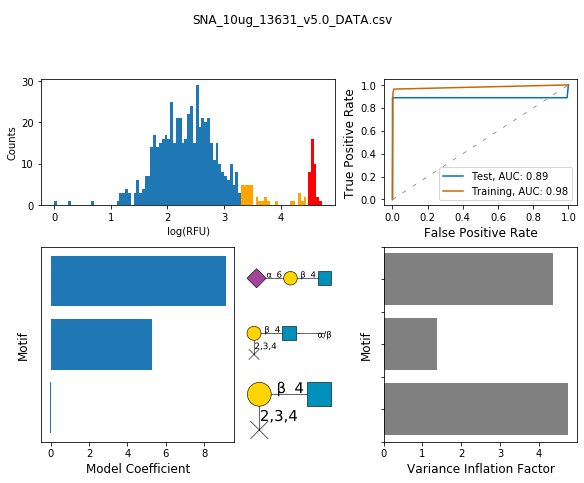

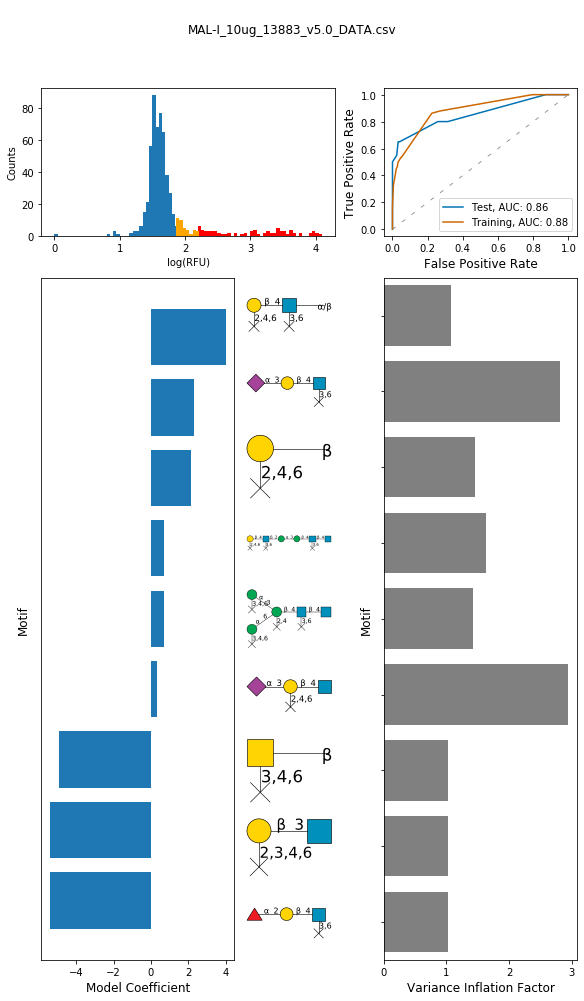

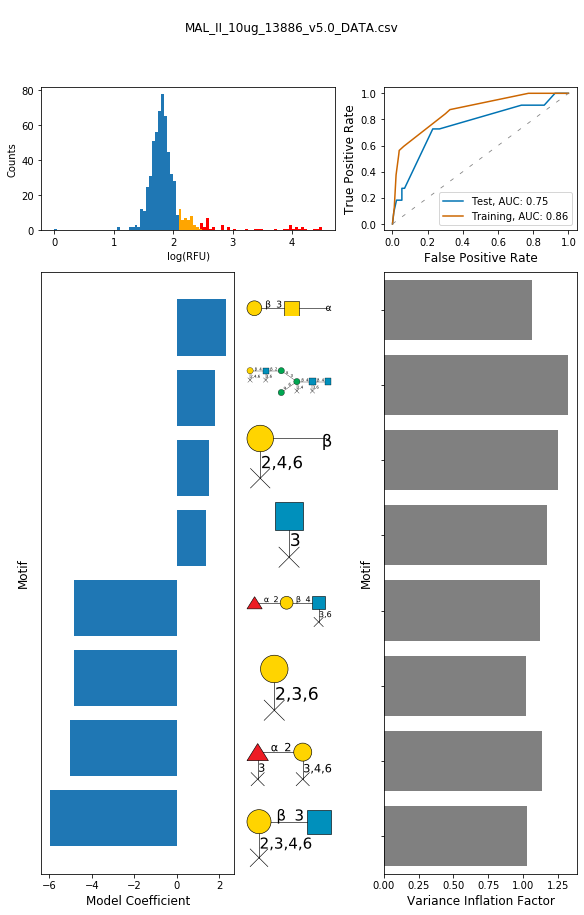

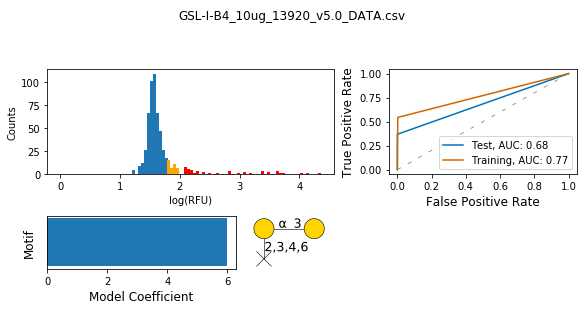

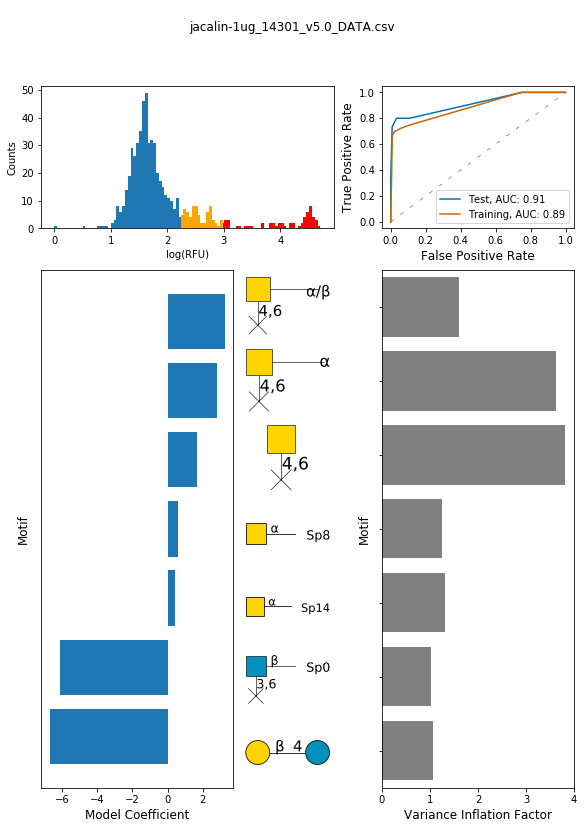

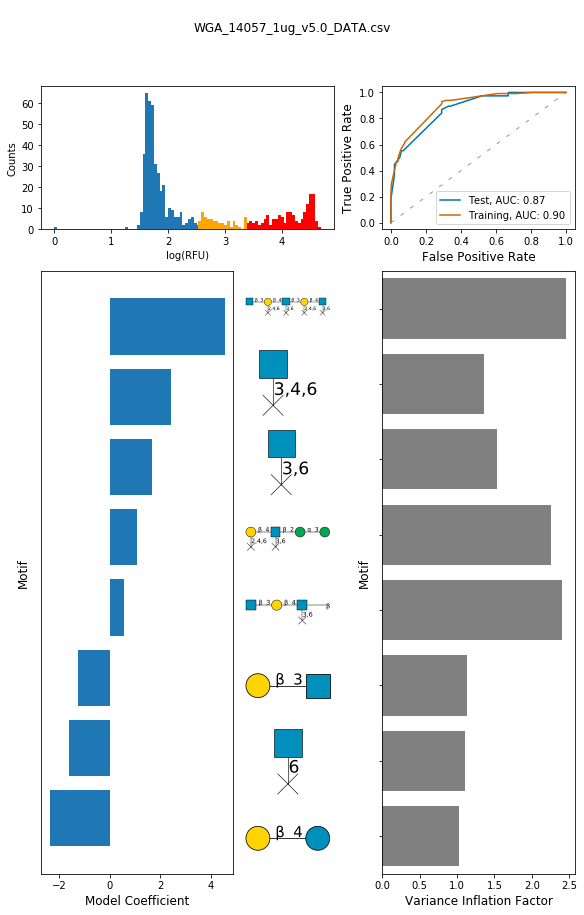

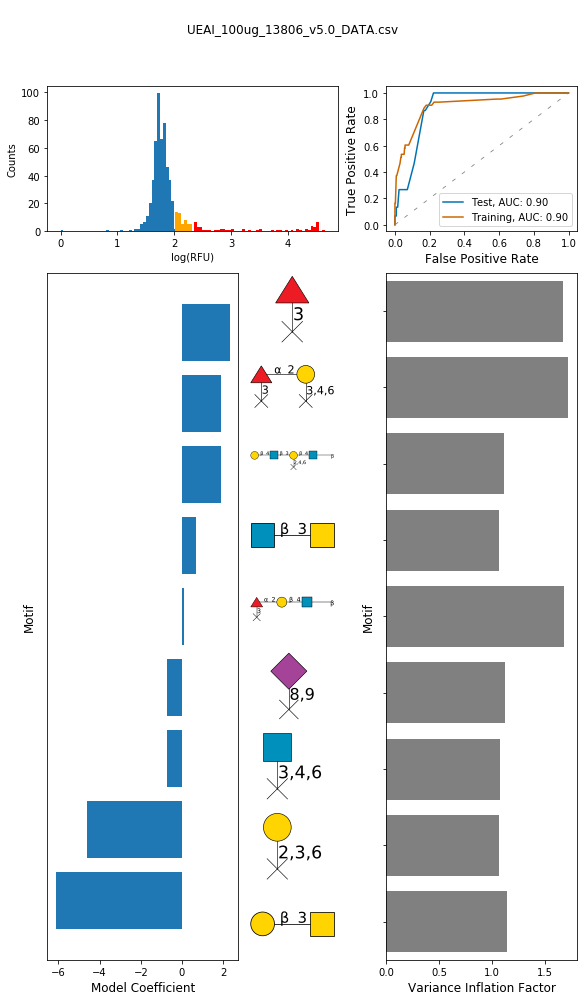

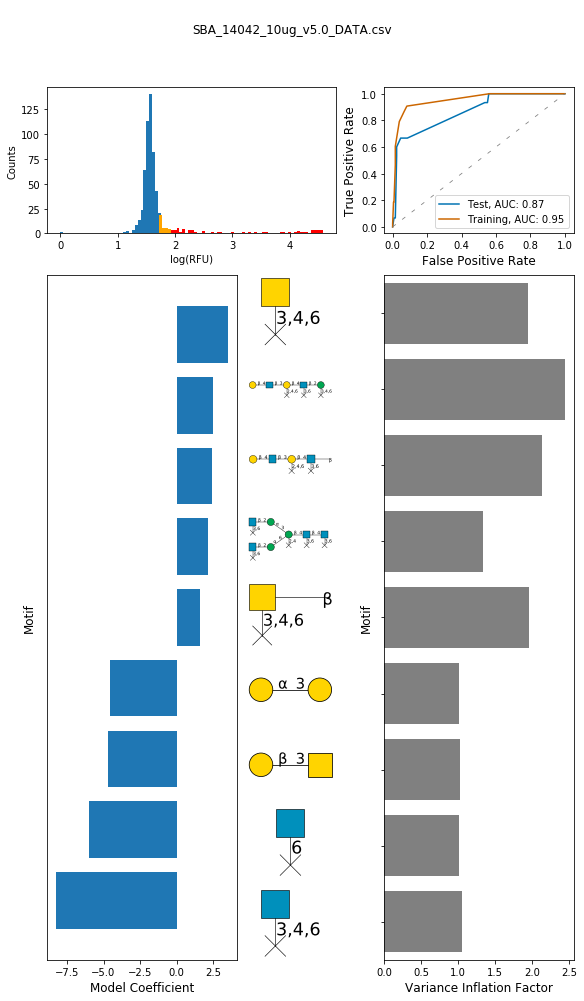

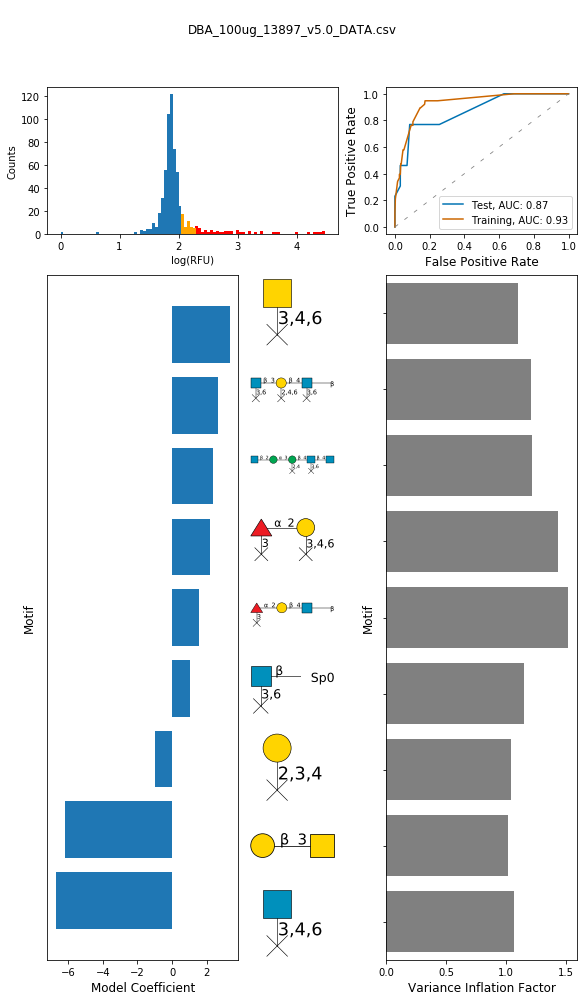

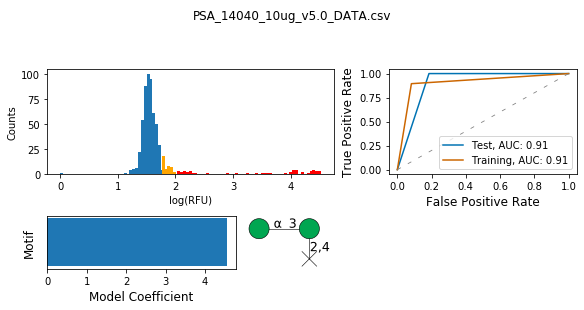

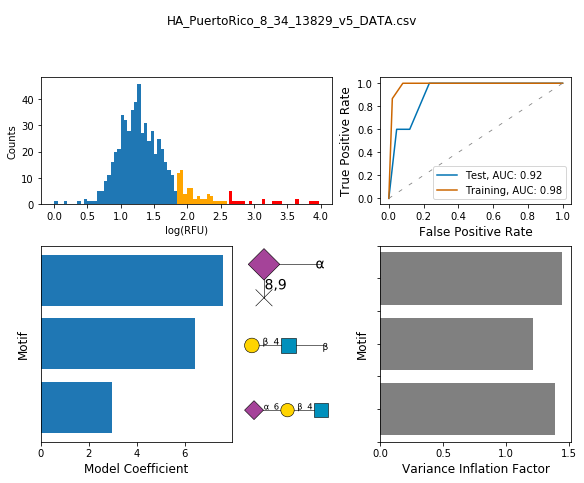

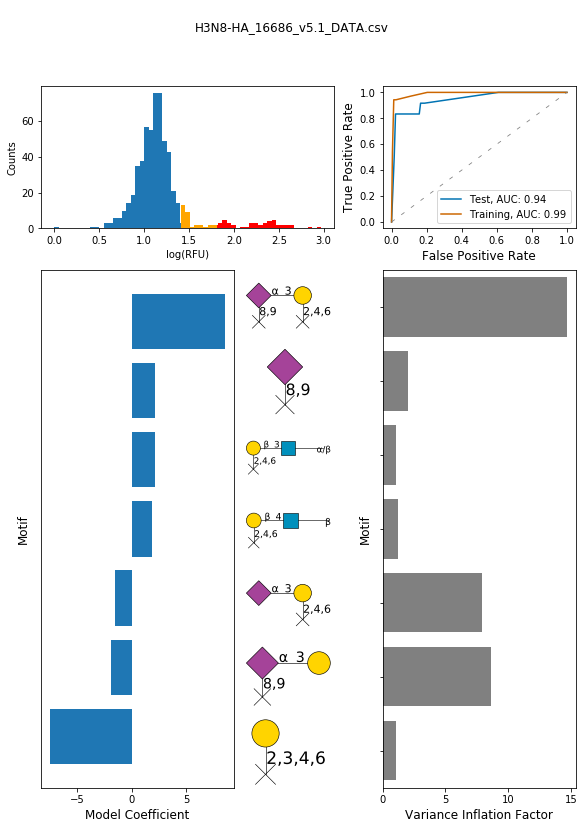

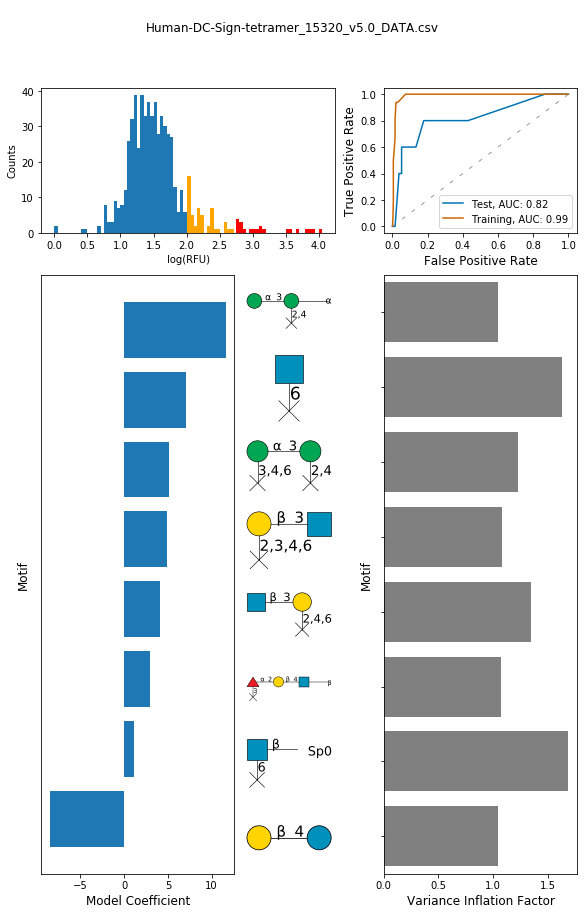

In [15]:
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages

def plot_model_coefficient_horiz(model, rfu, binders, outprefix, data_test, data_train, title):
    

    #fig, ax = plt.subplots(figsize=(4, 3))
    coefs = model._model.coef_[0]
    features = model.subtree_features
    sorted_features = [x for _, x in sorted(zip(coefs, features), key=lambda pair: -pair[0])]
    #fig, ax = plt.subplots(nrows=len(coefs), figsize=(2, 1 * len(coefs)))
    fig = plt.figure(constrained_layout=True, figsize=(8, 1.2 * len(coefs) + 3))
    fig.suptitle(title)
    gs = GridSpec(len(sorted_features) + 3, 5, width_ratios=[2, 2, 2, 2, 2], figure=fig)
    ax3 = fig.add_subplot(gs[1:3, 0:3])
    ax1 = fig.add_subplot(gs[3:, 0:2])
    ax2 = fig.add_subplot(gs[3:, 3:])
    ax4 = fig.add_subplot(gs[1:3, 3:])
    plot_test_training_roc_ax(model, data_test.binding.values, data_test.glycan,
                           data_train.binding.values, data_train.glycan, ax4)

    plot_log_rfu_histogram(rfu, binders, ax3)
    ax = {}
    for i, feature in enumerate(sorted_features):
        ax[i + 3] = fig.add_subplot(gs[i + 3, 2])
        draw_glycan_diagram(feature, ax[i + 3], draw_terminal_connection_labels=True)

    ax1.set_title('')
    ax1.set_ylabel('Motif', fontsize=12)
    ax1.set_xlabel('Model Coefficient', fontsize=12)
    ax1.barh(range(0, len(coefs)), sorted(coefs, key=lambda x: x))#, orientation='horizontal')
    #ax.set_ylim([-10, 20])
    ax1.set_yticklabels([])
    ax1.yaxis.set_ticks_position('none')
    X = model._training_features

    if len(coefs) > 1:
        # For each Xi, calculate VIF
        vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        sorted_vif = [x for _, x in sorted(zip(coefs, vif), key=lambda pair: pair[0])]
        ax2.set_title('')
        ax2.set_ylabel('Motif', fontsize=12)
        ax2.set_xlabel('Variance Inflation Factor', fontsize=12)
        ax2.barh(range(1, len(vif) + 1), sorted_vif, color='gray')
        ax2.set_yticklabels([])
        ax2.set_ylim([0.5, len(vif) + 0.5])
    else:
        ax2.axis('off')
    fig.show()
    fig.savefig(f'{outprefix}_summary.svg')
    return fig

pp = PdfPages('./Figures/Summary/summary_pdf.pdf')

for csv_file in csv_files:
    data_point = results[csv_file]
    rfu_data = pd.read_csv(os.path.join('./Data/CFG_Data_Files/CFG_CSV_Data_Files/', csv_file)).RFU
    log_rfu = _log_rfu_values(rfu_data)
    binders = _calculate_binders(log_rfu, thresholds=(1.5, 3.5))
    fig = plot_model_coefficient_horiz(data_point['model'], log_rfu, binders, f'./Figures/Summary/{csv_file}',
                                data_point['test'], data_point['train'], csv_file)
    pp.savefig(fig)
    
pp.close()

No VIF for single feature!!
No VIF for single feature!!


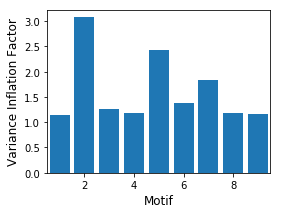

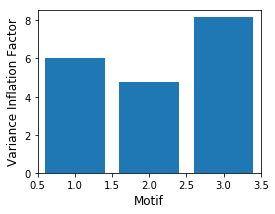

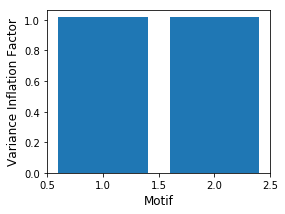

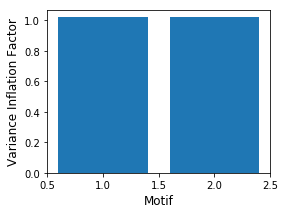

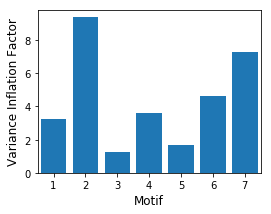

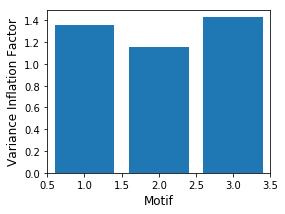

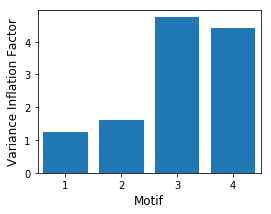

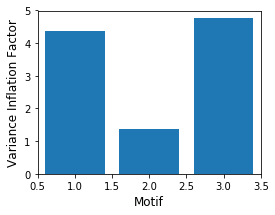

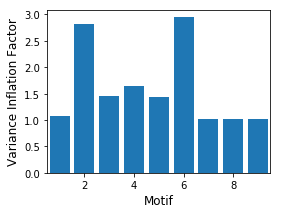

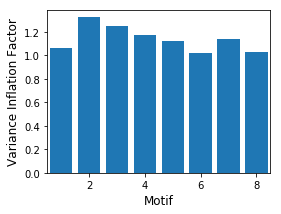

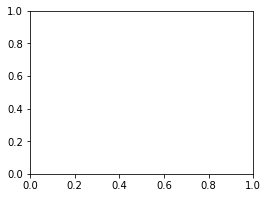

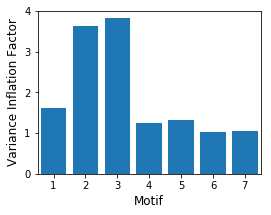

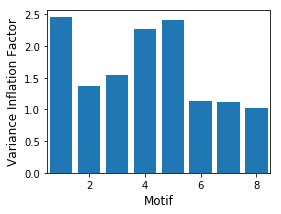

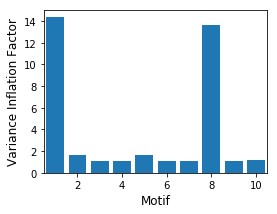

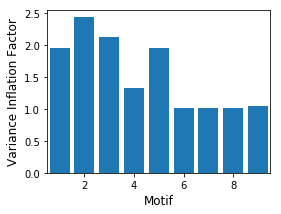

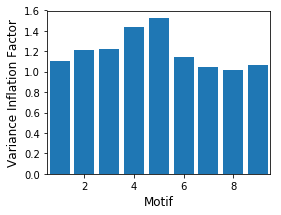

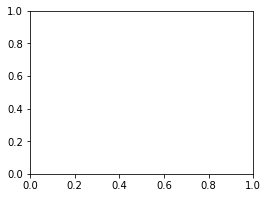

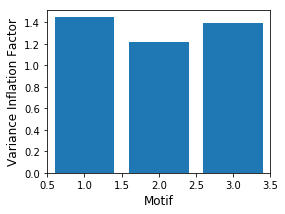

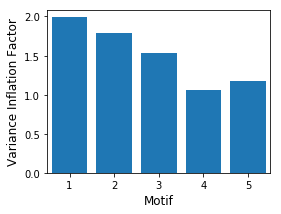

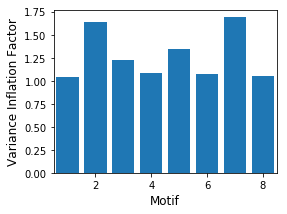

In [26]:


def plot_variance_inflation_factors(model, outprefix):
    fig, ax = plt.subplots(figsize=(4, 3))
    coefs = model._model.coef_[0]
    if len(coefs) == 1:
        print("No VIF for single feature!!")
        return
    X = model._training_features
    # For each Xi, calculate VIF
    vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    sorted_vif = [x for _, x in sorted(zip(coefs, vif), key=lambda pair: -pair[0])]
    ax.set_title('')
    ax.set_xlabel('Motif', fontsize=12)
    ax.set_ylabel('Variance Inflation Factor', fontsize=12)
    ax.bar(range(1, len(vif) + 1), sorted_vif)
    ax.set_xlim([0.5, len(vif) + 0.5])
    fig.savefig(f'{outprefix}_VIF.svg')
    return vif

vifs = []
for csv_file in csv_files:
    data_point = results[csv_file]
    vifs.append(plot_variance_inflation_factors(data_point['model'], f'./Figures/Coefficients/{csv_file}'))

In [33]:
# Calculate MCC and F1 score for each 

from sklearn.metrics import f1_score, matthews_corrcoef
    
with open('ccarl_benchmarks.csv', 'w') as out_file:
    out_file.write(','.join(["sample", "F1", "MCC"]) + '\n')
    for csv_file in csv_files:
        data_point = results[csv_file]
        clf = data_point['model']
        y_pred = clf.predict(data_point['test'].glycan)
        f1 = f1_score(data_point['test'].binding, y_pred)
        mcc = matthews_corrcoef(data_point['test'].binding, y_pred)
        out_file.write(f"{csv_file[0:-4]},{f1:0.3f},{mcc:0.3f}\n")

ABA_14361_100ug_v5.0_DATA
F1 Score: 0.625
MCC Score: 0.559
ConA_13799-10ug_V5.0_DATA
F1 Score: 0.862
MCC Score: 0.830
PNA_14030_10ug_v5.0_DATA
F1 Score: 0.722
MCC Score: 0.696
RCAI_10ug_14110_v5.0_DATA
F1 Score: 0.898
MCC Score: 0.876
PHA-E-10ug_13853_V5.0_DATA
F1 Score: 0.792
MCC Score: 0.755
PHA-L-10ug_13856_V5.0_DATA
F1 Score: 0.609
MCC Score: 0.639
LCA_10ug_13934_v5.0_DATA
F1 Score: 0.682
MCC Score: 0.678
SNA_10ug_13631_v5.0_DATA
F1 Score: 0.941
MCC Score: 0.939
MAL-I_10ug_13883_v5.0_DATA
F1 Score: 0.471
MCC Score: 0.398
MAL_II_10ug_13886_v5.0_DATA
F1 Score: 0.296
MCC Score: 0.268
GSL-I-B4_10ug_13920_v5.0_DATA
F1 Score: 0.538
MCC Score: 0.580
jacalin-1ug_14301_v5.0_DATA
F1 Score: 0.774
MCC Score: 0.746
WGA_14057_1ug_v5.0_DATA
F1 Score: 0.646
MCC Score: 0.497
UEAI_100ug_13806_v5.0_DATA
F1 Score: 0.517
MCC Score: 0.521
SBA_14042_10ug_v5.0_DATA
F1 Score: 0.556
MCC Score: 0.503
DBA_100ug_13897_v5.0_DATA
F1 Score: 0.465
MCC Score: 0.434
PSA_14040_10ug_v5.0_DATA
F1 Score: 0.520
MCC Score